# Desafio Final: Caixeiro Viajante com Algoritmos Meméticos
**Grupo:** [Nean, Paulo, Pedro, Tainara]


## 1. Definição do Problema e Instância
Neste notebook, resolvemos o **Problema do Caixeiro Viajante (TSP)** utilizando uma abordagem **Memética** (Híbrida).
* **Objetivo:** Minimizar a distância Euclidiana total.
* **Restrição:** Sair da cidade 0, visitar as cidades 1-16 e retornar à 0.
* **Instância:** 17 cidades com coordenadas fixas.

Abaixo, definimos as coordenadas e os hiperparâmetros calibrados para garantir convergência e diversidade.

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import copy

# --- 1. DADOS DO PROBLEMA ---
# Mapeamento exato das coordenadas fornecidas no desafio
coords_dict = {
    0: (50, 50), 1: (20, 20), 2: (40, 20), 3: (60, 20), 4: (80, 20),
    5: (20, 40), 6: (40, 40), 7: (60, 40), 8: (80, 40), 9: (20, 60),
    10: (40, 60), 11: (60, 60), 12: (80, 60), 13: (20, 80), 14: (40, 80),
    15: (60, 80), 16: (80, 80)
}

# Transformando em array para acesso rápido
cities = np.array([coords_dict[i] for i in range(17)])
NUM_CITIES = len(cities)

# --- 2. HIPERPARÂMETROS ---
#  População de 100 é suficiente para N=17.
# Taxa de Mutação de 15% (alta) compensa a perda de diversidade causada pela Busca Local.
POPULATION_SIZE = 100
GENERATIONS = 200
MUTATION_RATE = 0.15
LOCAL_SEARCH_RATE = 0.5  # 50% de pressão Memética
ELITE_SIZE = 5           # Mantém os 5 melhores intocados

# Seed para reprodutibilidade
random.seed(42)
np.random.seed(42)

## 2. Função de Aptidão (Fitness)
A função objetivo calcula a distância Euclidiana total da rota.
**Detalhe Importante:** O cromossomo do indivíduo contém apenas a permutação das cidades `[1, ..., 16]`. A cidade `0` (Depósito) é adicionada manualmente no início e no fim dentro da função de cálculo para garantir o ciclo fechado.

In [ ]:
def euclidean_distance(c1, c2):
    """Cálculo vetorial da distância Euclidiana."""
    return np.sqrt(np.sum((c1 - c2)**2))

def calculate_fitness(route_idxs):
    """
    Função Objetivo: Minimização da Distância Total.
    Reconstrói o ciclo completo: 0 -> rota -> 0
    """
    # Adiciona a cidade 0 no início e fim
    full_route_idxs = [0] + route_idxs + [0]

    total_dist = 0.0
    for i in range(len(full_route_idxs) - 1):
        p1 = cities[full_route_idxs[i]]
        p2 = cities[full_route_idxs[i+1]]
        total_dist += euclidean_distance(p1, p2)

    return total_dist

## 3. Operadores Genéticos (Busca Global)
Utilizamos operadores específicos para problemas de permutação:
* **Crossover OX1 (Order Crossover):** Preserva a ordem relativa das cidades dos pais, evitando rotas inválidas.
* **Mutação Swap:** Troca duas cidades de lugar para introduzir variabilidade genética.

In [ ]:
def create_individual():
    """Gera permutação aleatória de [1..16]. 0 é fixo."""
    ind = list(range(1, NUM_CITIES))
    random.shuffle(ind)
    return ind

def order_crossover(parent1, parent2):
    """
    Operador OX1 (Order Crossover).
    Essencial para TSP pois evita duplicação de cidades.
    """
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))

    child = [-1] * size
    child[start:end] = parent1[start:end]

    current_pos = 0
    for gene in parent2:
        if gene not in child:
            while child[current_pos] != -1:
                current_pos += 1
            child[current_pos] = gene
    return child

def swap_mutation(individual):
    """Mutação por troca simples (O(1))."""
    if random.random() < MUTATION_RATE:
        idx1, idx2 = random.sample(range(len(individual)), 2)
        individual[idx1], individual[idx2] = individual[idx2], individual[idx1]
    return individual

## 4. Operador Memético: Busca Local (Refinamento)
Aqui reside o diferencial do algoritmo. Aplicamos a técnica **2-Opt** como forma de aprendizado individual.
O 2-Opt verifica se existem arestas cruzadas na rota ("nós") e as desembaraça, garantindo eficiência geométrica. Utilizamos o modelo **Lamarckiano**, onde a melhoria aprendida pelo indivíduo é gravada em seu DNA e passada para a próxima geração.

In [ ]:
def local_search_2opt(individual):
    """
    Algoritmo 2-Opt (Refinamento Local).
    Remove cruzamentos de arestas invertendo segmentos da rota.
    """
    # Adiciona 0 temporariamente para considerar arestas ligadas à base
    route = [0] + individual + [0]
    best_route = route[:]
    improved = True

    while improved:
        improved = False
        current_cost = calculate_fitness(best_route[1:-1])

        # Testa todas as trocas de arestas possíveis
        for i in range(1, len(route) - 2):
            for j in range(i + 1, len(route) - 1):
                if j - i == 1: continue

                # Cria nova rota invertendo segmento
                new_route = best_route[:]
                new_route[i:j] = best_route[j-1:i-1:-1]

                new_cost = calculate_fitness(new_route[1:-1])

                if new_cost < current_cost:
                    best_route = new_route
                    improved = True
                    break
            if improved: break

    return best_route[1:-1] # Retorna gene limpo

## 5. Execução do Algoritmo
Rodamos o ciclo evolutivo combinando seleção, cruzamento, mutação e busca local.
Monitoramos o tempo de execução e a convergência a cada geração.

In [ ]:
print(f"--- INICIANDO ALGORITMO MEMÉTICO ---")
start_time = time.time()

population = [create_individual() for _ in range(POPULATION_SIZE)]
history_best = []

for gen in range(GENERATIONS):
    # 1. Avaliação
    population.sort(key=calculate_fitness)
    best_fitness = calculate_fitness(population[0])
    history_best.append(best_fitness)

    if gen % 20 == 0:
        print(f"[Gen {gen:03d}] Melhor Custo: {best_fitness:.4f}")

    # 2. Elitismo
    new_population = population[:ELITE_SIZE]

    # 3. Reprodução
    while len(new_population) < POPULATION_SIZE:
        parents = random.sample(population[:50], 2) # Torneio top 50%

        child = order_crossover(parents[0], parents[1])
        child = swap_mutation(child)

        # 4. fase memética (Chance de Aprender)
        if random.random() < LOCAL_SEARCH_RATE:
            child = local_search_2opt(child)

        new_population.append(child)

    population = new_population

end_time = time.time()
runtime = end_time - start_time

--- INICIANDO ALGORITMO MEMÉTICO ---
[Gen 000] Melhor Custo: 590.6782
[Gen 020] Melhor Custo: 328.2843
[Gen 040] Melhor Custo: 328.2843
[Gen 060] Melhor Custo: 328.2843
[Gen 080] Melhor Custo: 328.2843
[Gen 100] Melhor Custo: 328.2843
[Gen 120] Melhor Custo: 328.2843
[Gen 140] Melhor Custo: 328.2843
[Gen 160] Melhor Custo: 328.2843
[Gen 180] Melhor Custo: 328.2843


## 6. Resultados e Visualização
Abaixo apresentamos:
1.  **Dados numéricos:** Rota, custo final e tempo.
2.  **Gráfico 1 (Mapa):** A rota visualizada no plano 2D. Espera-se um perímetro limpo sem cruzamentos.
3.  **Gráfico 2 (Convergência):** A evolução da aptidão ao longo das gerações.


       RELATÓRIO FINAL       
1. Melhor Tour (IDs): [0, 11, 15, 16, 12, 8, 4, 3, 2, 1, 5, 9, 13, 14, 10, 6, 7, 0]
2. Custo Total: 328.2843
3. Tempo de Execução: 210.2720 segundos


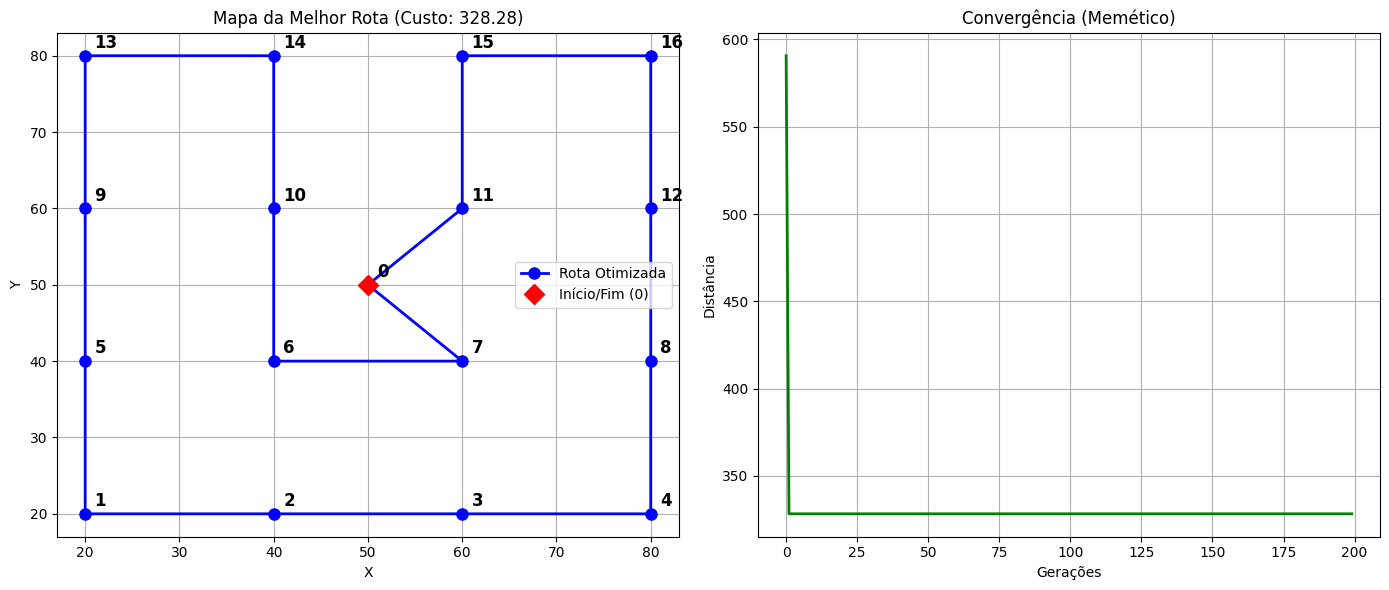

In [ ]:
best_ind = population[0]
final_cost = calculate_fitness(best_ind)
full_tour = [0] + best_ind + [0] # Rota completa para plotagem

print("\n" + "="*40)
print("       RELATÓRIO FINAL       ")
print("="*40)
print(f"1. Melhor Tour (IDs): {full_tour}")
print(f"2. Custo Total: {final_cost:.4f}")
print(f"3. Tempo de Execução: {runtime:.4f} segundos")
print("="*40)

# --- VISUALIZAÇÃO ---
plt.figure(figsize=(14, 6))

# Mapa da Rota
plt.subplot(1, 2, 1)
x_vals = [cities[i][0] for i in full_tour]
y_vals = [cities[i][1] for i in full_tour]

plt.plot(x_vals, y_vals, 'o-b', linewidth=2, markersize=8, label='Rota Otimizada')
plt.plot(cities[0][0], cities[0][1], 'D', color='red', markersize=10, label='Início/Fim (0)')

# Adiciona números nas cidades para conferência
for i in range(NUM_CITIES):
    plt.annotate(str(i), (cities[i][0]+1, cities[i][1]+1), fontsize=12, fontweight='bold')

plt.title(f"Mapa da Melhor Rota (Custo: {final_cost:.2f})")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)

# Convergência
plt.subplot(1, 2, 2)
plt.plot(history_best, color='green', linewidth=2)
plt.title("Convergência (Memético)")
plt.xlabel("Gerações")
plt.ylabel("Distância")
plt.grid(True)

plt.tight_layout()
plt.show()